## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!

#### Import necessary packages, setup dataframe

In [2]:
#import 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import OrdinalEncoder


%matplotlib inline

In [3]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

# Exploratory Data Analysis (EDA)

With the data loaded, we're able to perform EDA.
We're looking to answer our business questions, so first we'll cut out all fields that we don't need.
We'll also OneHotEncode categorical values so that we can perform regression on them.
Finally, we've also changed some columns to binary values to help us answer our business questions.
Our changes to the dataframe are as follows:

`id` - DEL

`date` - DEL

`price` - Sale price (prediction target)
Is normally distributed at lower prices, but has many outliers over 2.3mil.
Houses sold at outlier amounts are removed.

`bedrooms` - Number of bedrooms

`bathrooms` - Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom).
Change 0 bathroom to 1 bathroom. Round up other values.

`sqft_living` - Square footage of living space in the home

`sqft_lot` - DEL

`floors` - DEL

`waterfront` - ONEHOT

`greenbelt` - BINARY

`nuisance` - BINARY

`view` - ORDINAL

`condition` - ORDINAL

`grade` - DEL

`heat_source` - DEL

`sewer_system` - BINARY

`sqft_above` - DEL

`sqft_basement` - BINARY

`sqft_garage` - BINARY

`sqft_patio` - BINARY

`yr_built` - Year when house was built

`yr_renovated` - BINARY

`address` - GET ZIP, ONEHOT

`lat` - DEL

`long` - DEL

In [17]:
df_original = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

In [4]:
# Examine the data types for each of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

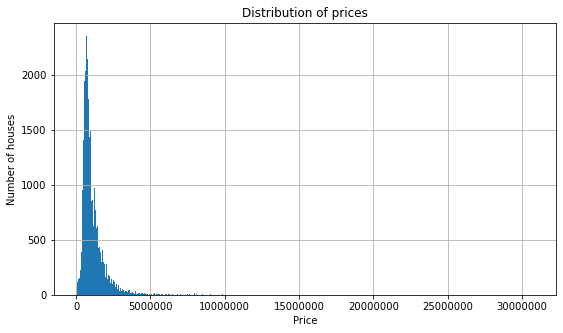

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df['price'].hist(bins=500, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

Here we see the housing prices spread. We limit the prices to 5 million initially, as our stakeholders wish to not spend more than 5mil.

We still see many outliers as determined by an IQR test. We use IQR here as the dataset is skewed. We limit the prices again to exclude outliers for more accurate analysis when regression is used later.

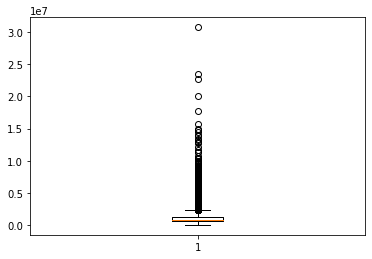

In [6]:
plt.boxplot(df['price']);

In [7]:
df = df.loc[df['price']<5000000]
# IQR
Q1 = np.percentile(df['price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Upper bound
upper_limit = Q3 + 1.5 * IQR
upper_limit

# Trim
df = df[df['price'] < upper_limit]

<ipython-input-7-4f6cfea0a594>:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q1 = np.percentile(df['price'], 25,
<ipython-input-7-4f6cfea0a594>:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  Q3 = np.percentile(df['price'], 75,


We'll continue to change the rest of the dataframe to make it more accessible.

In [8]:
# Quasi-categorical(0.5 + 0.5 bathrooms != 1 bathroom). Change 0 bathroom to 1 bathroom. Round up other values.
df.loc[df['bathrooms'] == 0, 'bathrooms'] = 1
df['bathrooms'] = df['bathrooms'].apply(np.ceil)

# Drop unnecessary columns
df.drop(['id', 'date', 'sqft_lot', 'floors', 'grade',
         'heat_source','sqft_above','lat','long'], axis=1, inplace=True)

# Create binary substitutes for columns
df['basement_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_basement']]
df['garage_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_garage']]
df['patio_binary'] = [1 if sq >  0  else 0 for sq in df['sqft_patio']]
df['waterfront_binary'] = [1 if sq == 'YES'  else 0 for sq in df['waterfront']]

# Create zip from address
df['zip'] = [x.split(',')[2][-5:] for x in df['address']] 

# Create binary values for greenbelt, nuisance
# Using OneHotEncoder

greenbelt_cat = df[['greenbelt']]
encoder_greenbelt = OrdinalEncoder()
encoder_greenbelt.fit(greenbelt_cat)
encoder_greenbelt.categories_[0]
greenbelt_encoded_train = encoder_greenbelt.transform(greenbelt_cat)
greenbelt_encoded_train = greenbelt_encoded_train.flatten()
# greenbelt_encoded_train
df["greenbelt"] = greenbelt_encoded_train

nuisance_cat = df[['nuisance']]
encoder_nuisance = OrdinalEncoder()
encoder_nuisance.fit(nuisance_cat)
encoder_nuisance.categories_[0]
nuisance_encoded_train = encoder_nuisance.transform(nuisance_cat)
nuisance_encoded_train = nuisance_encoded_train.flatten()
df["nuisance"] = nuisance_encoded_train

# Create Ordinal Values for condition
# Using OneHotEncoder
condition_cat = df[['condition']]
condition_categories = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
encoder_condition = OrdinalEncoder(categories=[condition_categories])
encoder_condition.fit(condition_cat)
condition_encoded_train = encoder_condition.transform(condition_cat)
condition_encoded_train = condition_encoded_train.flatten()
df["condition"] = condition_encoded_train

# Create Ordinal Values for view
# Using OneHotEncoder
view_cat = df[['view']]
view_categories = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
encoder_view = OrdinalEncoder(categories=[view_categories])
encoder_view.fit(view_cat)
encoder_view.categories_[0]
view_encoded_train = encoder_view.transform(view_cat)
view_encoded_train = view_encoded_train.flatten()
df["view"] = view_encoded_train



In [9]:
df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,greenbelt,nuisance,view,condition,sewer_system,...,sqft_garage,sqft_patio,yr_built,yr_renovated,address,basement_binary,garage_binary,patio_binary,waterfront_binary,zip
0,675000.0,4,1.0,1180,NO,0.0,0.0,0.0,3.0,PUBLIC,...,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",0,0,1,0,98055
1,920000.0,5,3.0,2770,NO,0.0,1.0,2.0,2.0,PUBLIC,...,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",1,0,1,0,98133
2,311000.0,6,2.0,2880,NO,0.0,0.0,2.0,2.0,PUBLIC,...,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",1,0,0,0,98178
3,775000.0,3,3.0,2160,NO,0.0,0.0,2.0,2.0,PUBLIC,...,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",1,1,1,0,98118
4,592500.0,2,2.0,1120,NO,0.0,1.0,0.0,2.0,PUBLIC,...,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",1,1,1,0,98027


In [10]:
#Identify the number of NAs / Nulls (blank)
df.isnull().sum()

price                 0
bedrooms              0
bathrooms             0
sqft_living           0
waterfront            0
greenbelt             0
nuisance              0
view                  0
condition             0
sewer_system         11
sqft_basement         0
sqft_garage           0
sqft_patio            0
yr_built              0
yr_renovated          0
address               0
basement_binary       0
garage_binary         0
patio_binary          0
waterfront_binary     0
zip                   0
dtype: int64

In [11]:
df['heat_source'].value_counts()

KeyError: 'heat_source'

In [ ]:
df['sewer_system'].value_counts()

Based on the value counts above, the null values can either be kept as is or changed to "Unknown".

# Data Analysis

Here, we begin to analyze the predictors/variables and test out our first linear regression. We start with sqft_living space, as our general assumption is that the bigger the living space, the higher the price of a given house.

In [ ]:
x = df[['sqft_living']]
y = df['price']

df_lineartest = sm.OLS(y, sm.add_constant(x)).fit().summary()

df_lineartest

In [13]:
df_predictors = df.drop(columns=['price'])

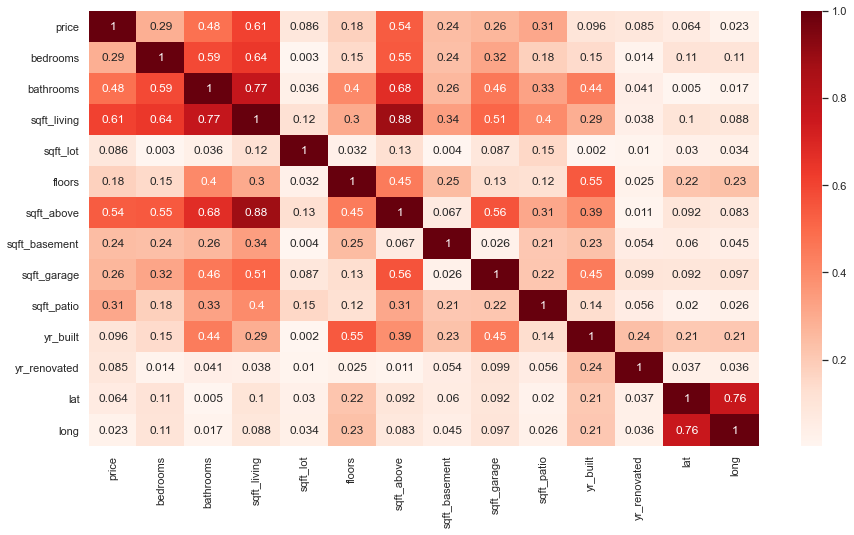

In [20]:
corr = round(abs(df_original.drop(columns = 'id').corr()),3)
sns.set(rc = {'figure.figsize':(15,8)})
Heatmap = sns.heatmap(corr, cmap="Reds", annot=True)
plt.savefig('Genre - horizontal Bar.png');
